In [ ]:
# TAREA 8/9 - Pronóstico

In [1]:
'''
Librerias a utilizar
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.decomposition import FactorAnalysis

In [2]:
df = pd.read_csv('/content/movies.csv')
df

,Unnamed: 0,id,title,overview,release_date,popularity,vote_average,vote_count
0,0,278,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,9/23/1994,26.9579,8.712,28675
1,1,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",3/14/1972,26.5804,8.686,21701
2,2,240,The Godfather Part II,In the continuing saga of the Corleone crime f...,12/20/1974,15.6559,8.571,13099
3,3,424,Schindler's List,The true story of how businessman Oskar Schind...,12/15/1993,12.5642,8.565,16616
4,4,389,12 Angry Men,The defense and the prosecution have rested an...,4/10/1957,14.6028,8.549,9307
...,...,...,...,...,...,...,...,...
8555,8555,238603,Earth to Echo,After a construction project begins digging in...,6/14/2014,1.6137,5.900,593
8556,8556,11968,Into the Blue,When they take some friends on an extreme spor...,9/30/2005,3.3432,5.902,1539
8557,8557,439079,The Nun,A priest with a haunted past and a novice on t...,9/5/2018,15.1733,5.901,6862
8558,8558,513409,Earthquake Bird,"Tokyo, Japan, 1989. Lucy Fly, a foreigner who ...",11/1/2019,1.1859,5.900,448


In [ ]:
'''
Retomando lo hecho rn las tareas previas
Aplicar al menos un algoritmo no supervisado a tus datos para encontrar estructuras subyacentes
'''

Buscando la mejor combinación de parámetros...

eps=0.2, min_samples=3, clusters=66, DBI=0.88
eps=0.2, min_samples=5, clusters=25, DBI=0.919
eps=0.2, min_samples=10, clusters=9, DBI=0.763
eps=0.5, min_samples=3, clusters=14, DBI=0.89
eps=0.5, min_samples=5, clusters=4, DBI=0.558
eps=0.5, min_samples=10, clusters=2, DBI=0.362
eps=0.8, min_samples=3, clusters=3, DBI=0.539
eps=0.8, min_samples=5, clusters=2, DBI=0.395
eps=1.0, min_samples=3, clusters=3, DBI=0.604
eps=1.0, min_samples=5, clusters=2, DBI=0.614
eps=1.5, min_samples=3, clusters=3, DBI=0.482

--- Mejor configuración encontrada ---
eps = 0.5, min_samples = 10, DBI = 0.362

Conteo de películas por cluster:
cluster
 0    8203
-1     347
 1      10
Name: count, dtype: int64


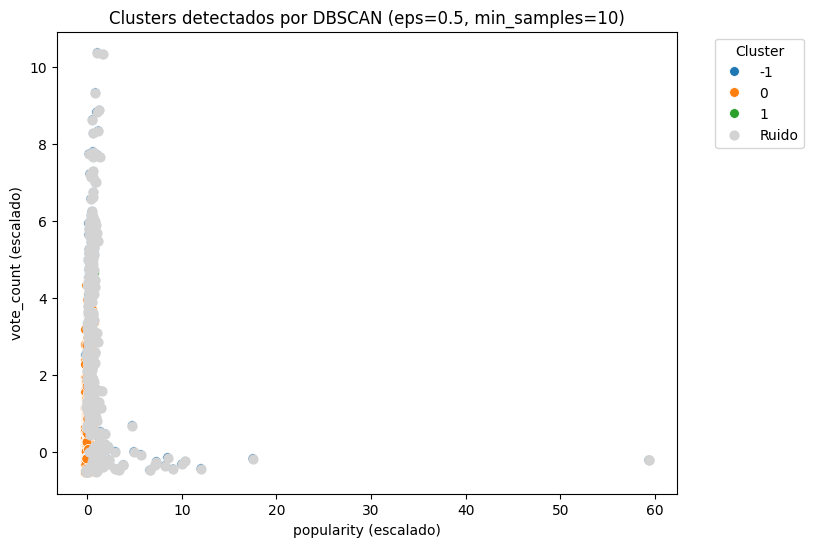

In [3]:
# Seleccionar solamente las columnas numéricas relevantes para nuestra investigación
X = df.select_dtypes(include=[np.number]).dropna()
X_scaled = StandardScaler().fit_transform(X)

# Búsqueda de parámetros: combinaciones de eps y min_samples
mejor_eps, mejor_min, mejor_dbi = None, None, np.inf
mejor_labels = None

print("Buscando la mejor combinación de parámetros...\n")

for eps in [0.2, 0.5, 0.8, 1.0, 1.5, 2.0]:
    for min_samples in [3, 5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Calcular DBI solo si hay al menos 2 clusters
        if n_clusters > 1:
            mask = labels != -1
            dbi = davies_bouldin_score(X_scaled[mask], labels[mask])

            print(f"eps={eps}, min_samples={min_samples}, clusters={n_clusters}, DBI={round(dbi,3)}")

            # Guardar la mejor configuración (menor DBI)
            if dbi < mejor_dbi:
                mejor_dbi = dbi
                mejor_eps = eps
                mejor_min = min_samples
                mejor_labels = labels

print("\n--- Mejor configuración encontrada ---")
print(f"eps = {mejor_eps}, min_samples = {mejor_min}, DBI = {round(mejor_dbi,3)}")

# Asignar los clusters al DataFrame
df["cluster"] = mejor_labels

# Conteo de películas por cluster
print("\nConteo de películas por cluster:")
print(df["cluster"].value_counts())

# --- Visualización de los clusters obtenidos ---
plt.figure(figsize=(8,6))

# Convertimos X_scaled a DataFrame para graficar con etiquetas
X_plot = pd.DataFrame(X_scaled, columns=X.columns)
X_plot["cluster"] = df["cluster"]

# Determinar qué variables usar para graficar
if "popularity" in X.columns and "vote_count" in X.columns:
    xvar, yvar = "popularity", "vote_count"
else:
    xvar, yvar = X.columns[:2]

# Graficar los clusters
sns.scatterplot(
    data=X_plot,
    x=xvar,
    y=yvar,
    hue="cluster",
    palette="tab10",
    s=50
)

# Resaltar puntos de ruido
plt.scatter(
    X_plot.loc[X_plot["cluster"] == -1, xvar],
    X_plot.loc[X_plot["cluster"] == -1, yvar],
    c="lightgray", label="Ruido", s=40
)

plt.title(f"Clusters detectados por DBSCAN (eps={mejor_eps}, min_samples={mejor_min})")
plt.xlabel(f"{xvar} (escalado)")
plt.ylabel(f"{yvar} (escalado)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

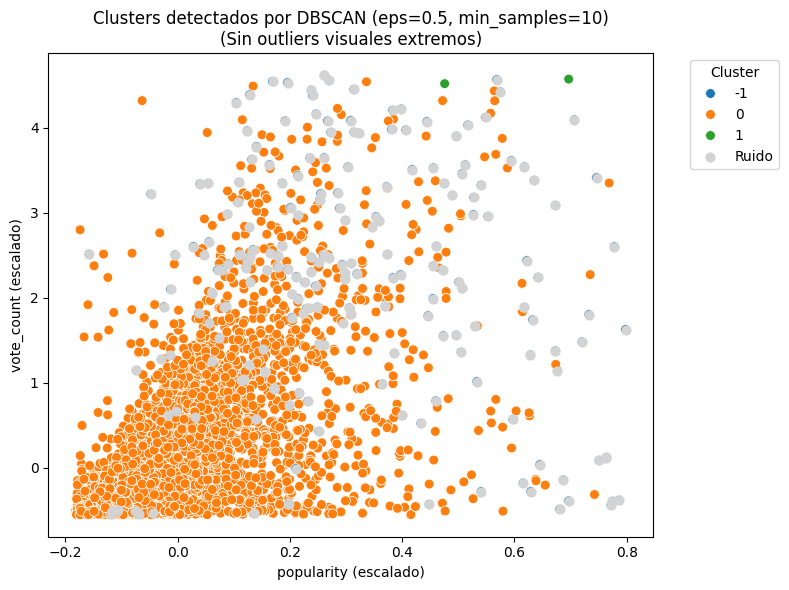

In [4]:
# Visualización mejorada de los clusters obtenidos

plt.figure(figsize=(8,6))

# Convertimos X_scaled a DataFrame para graficar con etiquetas
X_plot = pd.DataFrame(X_scaled, columns=X.columns)
X_plot["cluster"] = df["cluster"]

# Determinar qué variables usar para graficar
if "popularity" in X.columns and "vote_count" in X.columns:
    xvar, yvar = "popularity", "vote_count"
else:
    xvar, yvar = X.columns[:2]

# Detección y filtrado de outliers extremos para mejor visualización
# Usamos percentiles para definir un rango de valores "razonables"
p1_x, p99_x = np.percentile(X_plot[xvar], [1, 99])
p1_y, p99_y = np.percentile(X_plot[yvar], [1, 99])

# Filtramos los datos que están dentro de ese rango
X_vis = X_plot[
    (X_plot[xvar] >= p1_x) & (X_plot[xvar] <= p99_x) &
    (X_plot[yvar] >= p1_y) & (X_plot[yvar] <= p99_y)
]

# Y finalmente mejoramos la gráfica mostrando los clusters
sns.scatterplot(
    data=X_vis,
    x=xvar,
    y=yvar,
    hue="cluster",
    palette="tab10",
    s=50
)

# Resaltar puntos de ruido
plt.scatter(
    X_vis.loc[X_vis["cluster"] == -1, xvar],
    X_vis.loc[X_vis["cluster"] == -1, yvar],
    c="lightgray", label="Ruido", s=40
)

plt.title(f"Clusters detectados por DBSCAN (eps={mejor_eps}, min_samples={mejor_min})\n(Sin outliers visuales extremos)")
plt.xlabel(f"{xvar} (escalado)")
plt.ylabel(f"{yvar} (escalado)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
'''
continuando con lo solicitado en la tarea 6, ahora se aplica lo siguiente
Aplicar al menos un algoritmo supervisado a tus datos para predecir alguna variable (puede ser interpolación o extrapolación)

En este caso partiré de un Random Forest Regressor (ensamble) y una regresión lineal

Para esto se toma nuevamente como variable objetivo "vote_average" y como variables predictoras
"popularity", "vote_count" y el resto de variables numéricas

Tamién como métricas se usarán MAE, MSE, RMSE, MAPE y R².
Haciendo por último una evaluaión entrenamiento/prueba que resulta de la división 80/20.
'''

Variable objetivo (target): vote_average
Variables predictoras: ['Unnamed: 0', 'id', 'popularity', 'vote_count', 'cluster']

--- Regresión Lineal ---
MAE: 0.0598
MSE: 0.0085
RMSE: 0.0924
MAPE: 0.83%
R²: 0.9754

--- Random Forest ---
MAE: 0.0088
MSE: 0.0002
RMSE: 0.0132
MAPE: 0.13%
R²: 0.9995


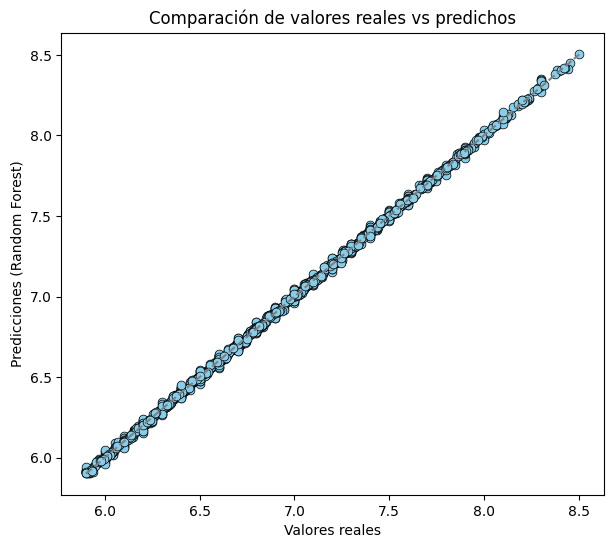

In [5]:
'''
Selección de variable objetivo (target) y variables predictoras (features)
'''
# Solo las columnas numéricas
X = df.select_dtypes(include=[np.number]).dropna().copy()

# Elegimos una variable a predecir (retomando vote_average)
if "vote_average" in X.columns:
    y = X["vote_average"]
    X = X.drop(columns=["vote_average"])
else:
    y = X.iloc[:, -1]
    X = X.iloc[:, :-1]

print("Variable objetivo (target):", y.name)
print("Variables predictoras:", list(X.columns))

'''
División de datos en entrenamiento y prueba
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

'''
Estandarizando...
'''
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

'''
Y los modelos a aplicar son:
1. Regresión Lineal
2. Random Forest Regressor
'''

# ---- RREGRESIÓN LINEAL ----
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# ---- RANDOM FOREST ----
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

'''
Funciones de métricas
'''
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, mape, r2

'''
Evaluación de modelos
'''
mae_lr, mse_lr, rmse_lr, mape_lr, r2_lr = metrics(y_test, y_pred_lr)
mae_rf, mse_rf, rmse_rf, mape_rf, r2_rf = metrics(y_test, y_pred_rf)

print("\n--- Regresión Lineal ---")
print(f"MAE: {mae_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAPE: {mape_lr*100:.2f}%")
print(f"R²: {r2_lr:.4f}")

print("\n--- Random Forest ---")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAPE: {mape_rf*100:.2f}%")
print(f"R²: {r2_rf:.4f}")

'''
Gráfica final de la comparación de los valores reales vs predichos
'''
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color="skyblue", s=40, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="gray")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones (Random Forest)")
plt.title("Comparación de valores reales vs predichos")
plt.show()


In [ ]:
'''
Siguiendo con las indicaciones de la tarea 8/9 se indica lo siguiente:
Revisar en la literatura las métricas de desempeño que se utilizan en tu problema.
Elige al menos una métrica para aplicar a tus modelos..
Realizar un diseño de experimentos para tu problema de estudio en la que indiques los niveles y tratamientos de interés.
Reporta estos hallazgos en el marco teórico de tu artículo.

Seleccioné el **RMSE** ya que resulta más sensible a errores grandes,
siendo ideal para comparar modelos de predicción continua como la recaudación de taquilla o el puntaje promedio de votación por película

definida como:
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Asimismo, para sistematizar el análisis, se planteó un **diseño factorial simple** con dos factores de interés:
- Algoritmo a nivel Random Forest
- Variables predictoras

Haciendo un diseño de experimentos nos permite medir cómo varía el desempeño
al modificar tanto el modelo como las variables de entrada, identificando la combinación óptima
para la predicción de popularidad o rendimiento comercial de cada película
'''

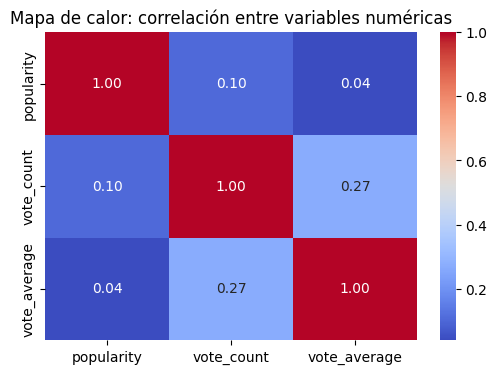

In [7]:
#  Muestra de las correlaciones entre variables predictoras y objetivo
corr = df[["popularity", "vote_count", "vote_average"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor: correlación entre variables numéricas")
plt.show()

In [15]:
# Comparación de métodos por RMSE junto a otros a partir de la regresión lineal y el random foreste
metrics_df = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Random Forest"],
    "MAE": [mae_lr, mae_rf],
    "MSE": [mse_lr, mse_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "MAPE (%)": [mape_lr*100, mape_rf*100],
    "R²": [r2_lr, r2_rf]
})

display(metrics_df.style.background_gradient(cmap="Blues", subset=["R²"]))

,Modelo,MAE,MSE,RMSE,MAPE (%),R²
0,Regresión Lineal,0.059806,0.008537,0.092398,0.827199,0.975443
1,Random Forest,0.008811,0.000174,0.013179,0.128410,0.999500


/tmp/ipython-input-2323291353.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla_experimentos = df.groupby(["nivel_popularidad", "nivel_votos"])["vote_average"].mean().reset_index()


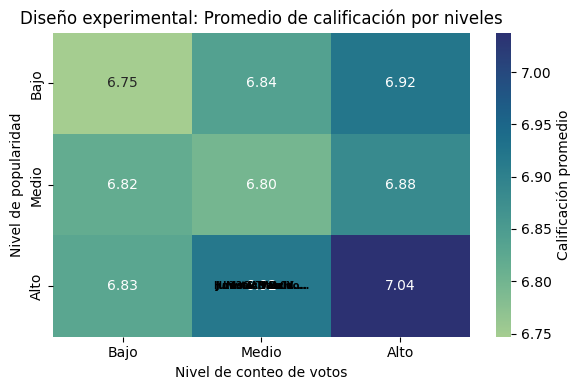

Películas más vistas (según popularidad):


,title,popularity,nivel_popularidad,nivel_votos,vote_average
6340,Jurassic World Rebirth,1274.2264,Alto,Medio,6.410
6368,Jurassic World Rebirth,1274.2264,Alto,Medio,6.412
259,How to Train Your Dragon,379.0512,Alto,Medio,8.000
1017,M3GAN 2.0,261.6583,Alto,Medio,7.604
1989,Lilo & Stitch,225.9260,Alto,Medio,7.322


In [14]:
# DISEÑO DE EXPERIMENTOS
'''
Se definen dos factores: variables independientes (popularidad y conteo de votos)
y una variable de respuesta (calificación promedio):
'''

# Niveles definidos en función de los percentiles de las variables
df["nivel_popularidad"] = pd.qcut(df["popularity"], q=3, labels=["Bajo", "Medio", "Alto"])
df["nivel_votos"] = pd.qcut(df["vote_count"], q=3, labels=["Bajo", "Medio", "Alto"])

# Promedio de calificación promedio por combinación de niveles
tabla_experimentos = df.groupby(["nivel_popularidad", "nivel_votos"])["vote_average"].mean().reset_index()

plt.figure(figsize=(6,4))
pivot = tabla_experimentos.pivot(index="nivel_popularidad", columns="nivel_votos", values="vote_average")

sns.heatmap(
    pivot,
    annot=True, cmap="crest", fmt=".2f",
    cbar_kws={'label': 'Calificación promedio'}
)
plt.title("Diseño experimental: Promedio de calificación por niveles")
plt.xlabel("Nivel de conteo de votos")
plt.ylabel("Nivel de popularidad")

'''
Extensión: Agregamos las películas más vistas (mayor popularidad) dentro del heatmap.
'''

# Seleccionamos las 5 películas más populares
top_movies = df.nlargest(5, "popularity")[["title", "popularity", "nivel_popularidad", "nivel_votos", "vote_average"]]

# Colocamos los títulos (abreviados) sobre sus celdas correspondientes
for _, row in top_movies.iterrows():
    x = ["Bajo", "Medio", "Alto"].index(row["nivel_votos"])
    y = ["Bajo", "Medio", "Alto"].index(row["nivel_popularidad"])
    plt.text(
        x + 0.5, y + 0.5,
        row["title"][:15] + "…",  # truncamos para no saturar el gráfico
        ha="center", va="center",
        fontsize=7, color="black", fontweight="bold"
    )

plt.tight_layout()
plt.show()

'''
Entonces, cada celda representa una combinación de tratamiento,
y el color indica qué tan alta o baja es la calificación promedio.

Además, se muestran las películas más vistas (por popularidad)
dentro de las celdas correspondientes a sus niveles de popularidad y votos.
'''

# Mostrar tabla con las películas más vistas
print("Películas más vistas (según popularidad):")
display(top_movies)
